In [99]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import fetch_covtype
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.utils import shuffle
from sklearn.base import BaseEstimator
from sklearn.base import clone

In [37]:
covtype = fetch_covtype()
X, y = covtype.data, covtype.target

print(X.shape)
print(np.unique(y))

(581012, 54)
[1 2 3 4 5 6 7]


In [13]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.1)

In [30]:
X_small, X_unlabeled, y_small, _ = train_test_split(X_dev, y_dev, train_size=10000)

In [36]:
%%time

etrees = ExtraTreesClassifier(n_estimators=80, n_jobs=4)
scores = cross_val_score(etrees, X_small, y_small, cv=5)

print("5-folds cv score: %0.3f+/-%0.3f" % (np.mean(scores), np.std(scores)))

5-folds cv score: 0.836+/-0.005
CPU times: user 14.5 s, sys: 1.99 s, total: 16.5 s
Wall time: 6.12 s


In [68]:
np.random.uniform(size=(3, 4))

array([[ 0.29906499,  0.61963946,  0.07382687,  0.51198165],
       [ 0.75008411,  0.32665691,  0.38846908,  0.26959562],
       [ 0.56896242,  0.1422773 ,  0.06123208,  0.77610519]])

In [74]:
def shuffle_columns(X, copy=True, seed=0):
    rng = np.random.RandomState(seed)
    if copy:
        X = X.copy()
    for i in range(X.shape[1]):
        rng.shuffle(X[:, i])
    return X


def corrupt(X, copy=True, rate=0.1, seed=0):
    rng = np.random.RandomState(seed)
    if copy:
        X = X.copy()
    X_shuffled = shuffle_columns(X, seed=0)
    mask = rng.uniform(size=X.shape) < rate
    X[mask] = X_shuffled[mask]
    return X


def make_normality_problem(X, seed=0):
    data = np.vstack([X, shuffle_columns(X, seed=seed)])
    target = np.zeros(X.shape[0] * 2, dtype=np.int)
    target[:X.shape[0]] = 1
    return shuffle(data, target, random_state=seed)


X_normal, y_normal = make_normality_problem(X_small)

In [75]:
%%time

etrees_normality = ExtraTreesClassifier(n_estimators=80, n_jobs=4)
scores = cross_val_score(etrees_normality, X_normal, y_normal, cv=5)

print("5-folds cv score: %0.3f+/-%0.3f" % (np.mean(scores), np.std(scores)))

5-folds cv score: 0.978+/-0.001
CPU times: user 32 s, sys: 464 ms, total: 32.5 s
Wall time: 10 s


In [76]:
%%time

_ = etrees_normality.fit(X_normal, y_normal)

CPU times: user 8.47 s, sys: 55.8 ms, total: 8.53 s
Wall time: 2.38 s


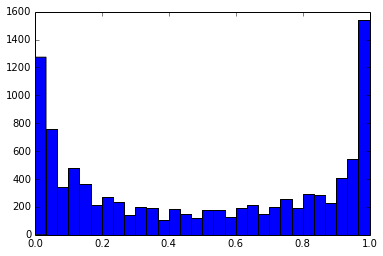

In [90]:
X_corrupted = corrupt(X_small, rate=0.2)

predicted_normality = etrees_normality.predict_proba(X_corrupted)[:, 1]
_ = plt.hist(predicted_normality, bins=30)

X_new_unlabeled = X_corrupted[predicted_normality > 0.5]
print(X_new_unlabeled.shape)

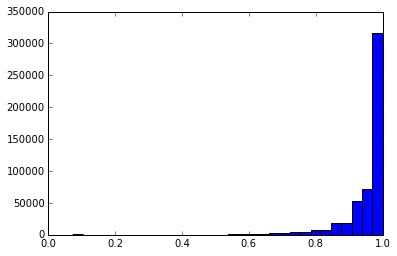

In [138]:
predicted_normality = etrees_normality.predict_proba(X_unlabeled)[:, 1]
_ = plt.hist(predicted_normality, bins=30)

In [133]:
class SelfTrainingClassifier(BaseEstimator):
    
    def __init__(self, base_estimator=None, n_iter=10, clamp_true_target=False):
        self.base_estimator = base_estimator
        self.n_iter = n_iter
        self.clamp_true_target = clamp_true_target
        
    def fit(self, X, y, X_unlabeled=None, X_val=None, y_val=None):
        if self.base_estimator is None:
            model = ExtraTreesClassifier(n_estimators=100)
        else:
            model = clone(self.base_estimator)
        
        X_train, y_train = X, y
               
        for i in range(self.n_iter):
            model.fit(X_train, y_train)
            
            if X_val is not None and y_val is not None:
                print(model.score(X_val, y_val))

            if self.clamp_true_target:
                y_predicted = y
            else:
                y_predicted = model.predict(X)
            
            X_train = np.vstack([X, X_unlabeled])
            y_train = np.concatenate([y, model.predict(X_unlabeled)])

        self.estimator_ = model
        
    def predict(self, X):
        return self.estimator_.predict(X)
    
    def score(self, X, y):
        return self.estimator_.score(X, y)
    

In [137]:
ssc = SelfTrainingClassifier(etrees).fit(X_small, y_small, X_new_unlabeled, X_val=X_test, y_val=y_test)

0.840573474235
0.834170940759
0.835203607449
0.83325875185
0.832897318509
0.835117551892
0.833620185192
0.833275962962
0.833585762969
0.833293174073
